In [1]:
suppressPackageStartupMessages({
  library(CHOIR)
  library(countsplit)
  library(ggnewscale)
  library(ragg)
  library(scRNAseq)
  library(Seurat)
  library(tictoc)
  library(ggplot2)
  library(dplyr)
  library(tidyr)
  library(purrr)
  library(pheatmap)
  library(SingleCellExperiment)
  library(org.Mm.eg.db)
  library(AnnotationDbi)
  library(clusterProfiler)
  library(dplyr)
  library(plyr)
})

Warning message:
“package ‘CHOIR’ was built under R version 4.4.3”
Warning message:
“package ‘countsplit’ was built under R version 4.4.3”
Warning message:
“package ‘ggnewscale’ was built under R version 4.4.3”
Warning message:
“package ‘ragg’ was built under R version 4.4.3”
Warning message:
“package ‘scRNAseq’ was built under R version 4.4.3”
Warning message:
“package ‘SingleCellExperiment’ was built under R version 4.4.3”
Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.4.3”
Warning message:
“package ‘MatrixGenerics’ was built under R version 4.4.3”
Warning message:
“package ‘matrixStats’ was built under R version 4.4.3”
Warning message:
“package ‘GenomicRanges’ was built under R version 4.4.3”
Warning message:
“package ‘Biobase’ was built under R version 4.4.3”
Warning message:
"package 'Seurat' was built under R version 4.4.3"
Warning message:
"package 'SeuratObject' was built under R version 4.4.3"
Warning message:
"package 'sp' was built under R versi

In [2]:
#Pull in the Chen et al., 2017 hypothalamus dataset as a SingleCellExperiment object
sce <- ChenBrainData(ensembl = TRUE, location = TRUE)

loading from cache

require("ensembldb")

Warning message:
"package 'ensembldb' was built under R version 4.4.3"
Warning message:
"package 'GenomicFeatures' was built under R version 4.4.3"
Warning message:
"package 'AnnotationFilter' was built under R version 4.4.3"
Warning message:
"Unable to map 2432 of 23284 requested IDs."


In [3]:
sce

class: SingleCellExperiment 
dim: 20852 14437 
metadata(0):
assays(1): counts
rownames(20852): ENSMUSG00000109644 ENSMUSG00000007777 ...
  ENSMUSG00000055670 ENSMUSG00000039068
rowData names(1): originalName
colnames(14437): B0CCCCGGGCTTGT_Normal B0ATTGGAATGGCC_Normal ...
  B4CATAGCCCACCC_Hungry2 B4CAATATGTCGGG_Hungry2
colData names(3): SVM_clusterID batch treatment
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [93]:
# Cluster ID assigned by the original study
unique(sce$SVM_clusterID)

[1] "Tany"    "GABA12"  "zothers" "Ependy"  "MO"      "GABA7"   "Epith2" 
 [8] "GABA16"  "Glu11"   "Glu5"    "IMO"     "Epith1"  "OPC"     "GABA8"  
[15] "Astro"   "Micro"   "Glu7"    "GABA15"  "GABA11"  "GABA17"  "Macro"  
[22] "Glu14"   "GABA13"  "GABA6"   "GABA18"  "GABA14"  "Glu8"    "Glu10"  
[29] "Glu2"    "GABA9"   "GABA3"   "GABA5"   "POPC"    "Glu4"    "Hista"  
[36] "GABA1"   "Glu13"   "GABA10"  "GABA4"   "Glu9"    "Glu15"   "GABA2"  
[43] "Glu3"    "Glu12"   "Glu6"    "Glu1"    "SCO"

In [6]:
gene_annot <- rowData(sce)

# Check what's there
head(gene_annot)

DataFrame with 6 rows and 1 column
                    originalName
                     <character>
ENSMUSG00000109644 0610005C13Rik
ENSMUSG00000007777 0610009B22Rik
ENSMUSG00000043644 0610009L18Rik
ENSMUSG00000042208 0610010F05Rik
ENSMUSG00000020831 0610010K14Rik
ENSMUSG00000107002 0610012G03Rik

In [8]:
gene_info <- data.frame(
  gene = rownames(sce),
  gene_symbol = gene_annot$originalName,
  ensembl_id = rownames(sce),
  stringsAsFactors = FALSE
)

head(gene_info)

,gene,gene_symbol,ensembl_id
,<chr>,<chr>,<chr>
1,ENSMUSG00000109644,0610005C13Rik,ENSMUSG00000109644
2,ENSMUSG00000007777,0610009B22Rik,ENSMUSG00000007777
3,ENSMUSG00000043644,0610009L18Rik,ENSMUSG00000043644
4,ENSMUSG00000042208,0610010F05Rik,ENSMUSG00000042208
5,ENSMUSG00000020831,0610010K14Rik,ENSMUSG00000020831
6,ENSMUSG00000107002,0610012G03Rik,ENSMUSG00000107002


In [9]:
# Extract the raw counts matrix (unnormalized and unfiltered)
# Rows: genes
# Columns: cells
counts_matrix <- as.matrix(assay(sce, "counts"))

# Assign column names explicitly from sce colnames if missing
if (is.null(colnames(counts_matrix))) {
  colnames(counts_matrix) <- colnames(sce)
}

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.2 GiB"


In [11]:
# Create Seurat object: filter genes and cells
object <- CreateSeuratObject(
  counts = counts_matrix,
  min.features = 100,   # min genes per cell
  min.cells = 5         # min cells per gene
)

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


In [13]:
length(colnames(object)) #I think count is less because of the filtering step above
length(colnames(sce))

[1] 14426

[1] 14437

In [14]:
# Make sure the size of sce is same as the seurat object
sce_filtered <- sce[, colnames(object)]
sce <- sce_filtered

# Verify
all(colnames(sce) == colnames(object))  # Should be TRUE

[1] TRUE

In [15]:
# Add gene annotations from rowData(sce) to the Seurat object
# Store gene annotations separately inside Seurat object's misc slot
object@misc$gene_annotations <- as.data.frame(rowData(sce))

# Normalize the data (log-normalization by default)
object <- NormalizeData(object)

# Seurat object now has gene annotations stored in: object@misc$gene_annotations
object

Normalizing layer: counts



An object of class Seurat 
15479 features across 14426 samples within 1 assay 
Active assay: RNA (15479 features, 0 variable features)
 2 layers present: counts, data

In [18]:
#Parallelize analysis
options(future.globals.maxSize = 2.0 * 1e9)
n_cores = 8

In [91]:
# COMMMENTING BECAUSE ALREADY CALCULATED

# #Use CHOIR func with default parameters
# object <- CHOIR(object, n_cores = n_cores)

# #Save CHOIR object
# saveRDS(object, file = "results/choir_object.rds")

In [19]:
#Read CHOIR object
object <- readRDS("results/choir_object.rds")

In [20]:
# Add original cluster labels to Seurat meta.data
object$Original_Cluster <- sce$SVM_clusterID

In [21]:
head(object@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,CHOIR_clusters_0.05,Original_Cluster
,<fct>,<dbl>,<int>,<int>,<chr>
1,SeuratProject,12201,4216,10,Tany
2,SeuratProject,10470,3638,3,GABA12
3,SeuratProject,9394,3435,3,GABA12
4,SeuratProject,6646,2971,3,zothers
5,SeuratProject,6546,2883,15,Ependy
6,SeuratProject,6638,2338,18,MO


In [22]:
names(object@misc$CHOIR$var_features)

[1] "P0_var_features" "P1_var_features" "P2_var_features" "P3_var_features"
[5] "P4_var_features" "P5_var_features" "P6_var_features" "P7_var_features"
[9] "P8_var_features"

## UMAP

In [23]:
object <- runCHOIRumap(object, reduction = "P0_reduction")
names(object@misc$CHOIR$reduction)

Calculating UMAP embeddings for 1 dimensionality reductions..

(1/1) 

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
09:52:43 UMAP embedding parameters a = 0.9922 b = 1.112

09:52:43 Read 14426 rows and found 50 numeric columns

09:52:43 Using Annoy for neighbor search, n_neighbors = 30

09:52:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:52:46 Writing NN index file to temp file /scratch/mchidrawar/RtmpztjElZ/file3cdcc715433a43

09:52:46 Searching Annoy index using 1 thread, search_k = 3000

09:52:51 Annoy recall = 100%

09:5

[1] "P0_reduction"      "P1_reduction"      "P2_reduction"     
 [4] "P3_reduction"      "P4_reduction"      "P5_reduction"     
 [7] "P6_reduction"      "P7_reduction"      "P8_reduction"     
[10] "P0_reduction_UMAP"

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."
Warning message:
"Data is of class matrix. Coercing to dgCMatrix."
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CHOIR clusters (α = 0.05)' in 'mbcsToSbcs': for α (U+03B1)"


agg_record_603940555 
                   2

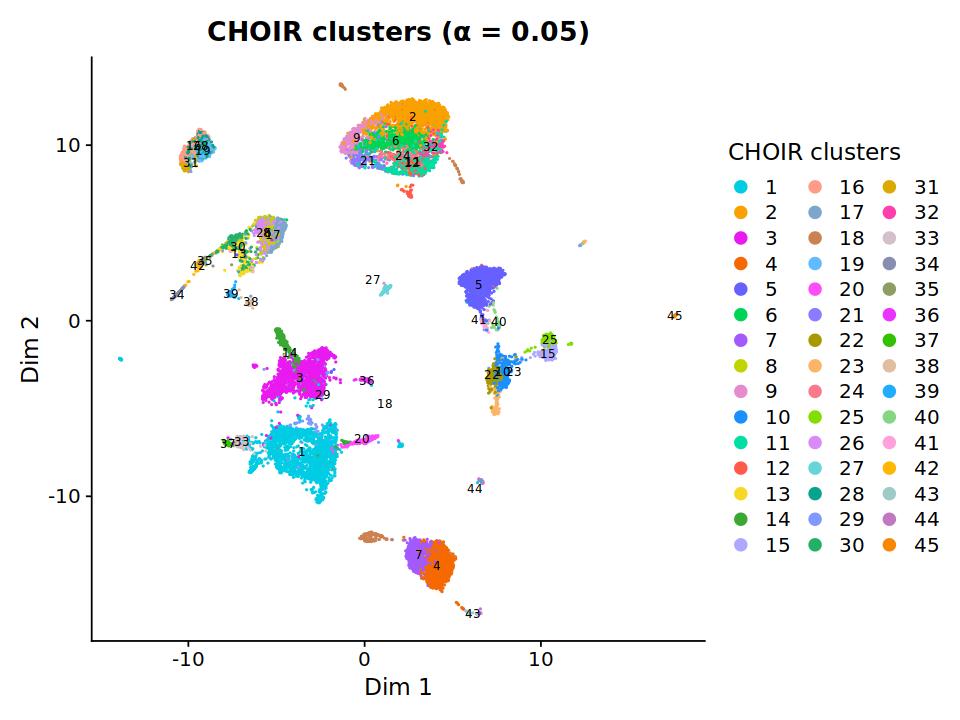

In [27]:
options(repr.plot.width = 8, repr.plot.height = 6)

# Display inline plot
plotCHOIR(object, key = "CHOIR", reduction = "P0_reduction_UMAP")

#Save to file
pdf(file = "results/CHOIR_umap_plot.pdf", width = 8, height = 6)
plotCHOIR(object, key = "CHOIR", reduction = "P0_reduction_UMAP")
dev.off()

## Generate markers and annotate

In [28]:
# Get top markers per CHOIR cluster using Seurat
# Set the cluster identities as the active identity of each cell
Idents(object) <- "CHOIR_clusters_0.05"

In [29]:
# Double check 
table(Idents(object))


  10    3   15   18   32   30   12   37   21    7   26   24   23   14   11    5 
 331 1444  272  203  105  119  305   71  180  510  150  155  157  276  305  965 
  28   22    2    1   20   36   25   29    4   27   39   33   17   40   43   38 
 131  160 1483 2059  193   73  150  128 1228  136   64  102  214   57   49   65 
  44   34   35   31    6   13   41    9    8   19   16   42   45 
  45   96   75  112  632  289   51  358  379  199  266   51   33 

In [30]:
# COMMMENTING BECAUSE ALREADY CALCULATED

# all_markers <- FindAllMarkers(
#   object,             # your Seurat object
#   only.pos = TRUE,    # only markers more expressed in cluster
#   min.pct = 0.25,     # gene expressed in at least 25% of cells in cluster
#   logfc.threshold = 0.25  # minimum log fold change of 0.25
# )

# # Now annotate the marker genes before saving
# all_markers <- all_markers %>%
#   left_join(gene_info, by = "gene")

# head(all_markers)

# # Save the annotated markers instead of raw
# saveRDS(all_markers, file = "results/all_markers.rds")

In [31]:
#Read all_markers object
all_markers <- readRDS("results/all_markers.rds")

In [38]:
all_markers_annotated <- all_markers

# Extract the gene symbols and map from your original sce rowData
gene_map <- data.frame(
  feature = rownames(sce),            # Ensembl IDs like ENSMUSG...
  gene_symbol = rowData(sce)$originalName,
  stringsAsFactors = FALSE
)

# Mapping from FeatureXXXX to Ensembl IDs.
# Extract numeric part of the Feature IDs in all_markers
all_markers_annotated$feature_num <- as.integer(gsub("Feature", "", all_markers_annotated$gene))

# Map gene symbols from sce rowData by row index
all_markers_annotated$gene_symbol <- gene_map$gene_symbol[all_markers_annotated$feature_num]

head(all_markers_annotated)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,gene_symbol,ensembl_id,feature_num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>
1,0,3.907476,0.906,0.129,0,10,Feature16091,S100a6,NA,16091
2,0,3.338149,0.825,0.117,0,10,Feature11190,Mlc1,NA,11190
3,0,4.615113,0.674,0.034,0,10,Feature4159,Col23a1,NA,4159
4,0,4.389235,0.665,0.059,0,10,Feature18343,Thrsp,NA,18343
5,0,3.032603,0.656,0.057,0,10,Feature5388,Dynlrb2,NA,5388
6,0,4.795309,0.495,0.025,0,10,Feature9294,Kctd14,NA,9294


In [39]:
# Save the annotated markers instead of raw
saveRDS(all_markers_annotated, file = "results/all_markers_annotated.rds")
write.csv(all_markers_annotated, "results/all_markers_annotated.csv", row.names = FALSE)

In [40]:
#Read all_markers object
all_markers_annotated <- readRDS("results/all_markers_annotated.rds")

## Compare results

In [41]:
# Original Clusters from the study
table(object$Original_Cluster)


  Astro  Ependy  Epith1  Epith2   GABA1  GABA10  GABA11  GABA12  GABA13  GABA14 
   1148     413     818     379      23      23      35      62     165      71 
 GABA15  GABA16  GABA17  GABA18   GABA2   GABA3   GABA4   GABA5   GABA6   GABA7 
    112      66      50      31      27      97      18      73      49      17 
  GABA8   GABA9    Glu1   Glu10   Glu11   Glu12   Glu13   Glu14   Glu15    Glu2 
    402      71      13      15      42      24      24      51      25      21 
   Glu3    Glu4    Glu5    Glu6    Glu7    Glu8    Glu9   Hista     IMO   Macro 
     13     131     200      51     211      50      35      17     151     167 
  Micro      MO     OPC    POPC     SCO    Tany zothers 
    724    3533    1741      51      32     609    2345 

In [42]:
# CHOIR clusters
table(object$CHOIR_clusters_0.05)


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2059 1483 1444 1228  965  632  510  379  358  331  305  305  289  276  272  266 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 214  203  199  193  180  160  157  155  150  150  136  131  128  119  112  105 
  33   34   35   36   37   38   39   40   41   42   43   44   45 
 102   96   75   73   71   65   64   57   51   51   49   45   33 

In [121]:
length(unique(object$Original_Cluster))
length(unique(object$CHOIR_clusters_0.05))

[1] 47

[1] 45

In [44]:
# Quick Overview - how the new clusters map onto the old ones
cross_tab <- table(object$CHOIR_clusters_0.05, object$Original_Cluster)
print(cross_tab)

    
     Astro Ependy Epith1 Epith2 GABA1 GABA10 GABA11 GABA12 GABA13 GABA14 GABA15
  1      2      1      0      0    22     19      4     16     64     35     38
  2      1      0      0      0     0      0      0      0      0      0      0
  3      0      0      0      1     1      4     30     45     96     36      2
  4      3      0      0      0     0      0      0      0      0      0      0
  5    963      0      0      0     0      0      0      0      0      0      0
  6      0      0      0      0     0      0      0      0      0      0      0
  7      0      0      0      0     0      0      0      0      0      0      0
  8      0      0    328     34     0      0      0      0      0      0      0
  9      0      0      0      0     0      0      0      0      0      0      0
  10    13      3      1      0     0      0      0      0      0      0      0
  11     1      0      0      0     0      0      0      0      0      0      0
  12    38      0      0      0    

In [45]:
# Convert the contingency table (cross-tabulation) to a data frame
cross_tab_df <- as.data.frame(cross_tab)

# Rename the columns of the data frame for clarity
# CHOIR_cluster: the cluster label assigned by CHOIR
# Original_cluster: the original cluster label (e.g., from Seurat or manual annotation)
# count: number of cells that belong to both the CHOIR and Original cluster
names(cross_tab_df) <- c("CHOIR_cluster", "Original_cluster", "count")

# For each CHOIR cluster, find the Original cluster that has the most overlapping cells
best_matches <- cross_tab_df %>%
  group_by(CHOIR_cluster) %>%
  slice_max(order_by = count, n = 1, with_ties = FALSE) %>%
  ungroup()

best_matches

CHOIR_cluster,Original_cluster,count
<fct>,<fct>,<int>
1,zothers,1056
2,MO,1482
3,zothers,844
4,OPC,1222
5,Astro,963
6,MO,628
7,OPC,507
8,Epith1,328
9,MO,349


## UMAPs by original clusters and choir clusters

In [55]:
# Extract the UMAP coords matrix from misc slot
umap_coords <- object@misc$CHOIR$reduction$P0_reduction_UMAP

# Add it as a DimReduc object to your Seurat object
object[["CHOIR_UMAP"]] <- CreateDimReducObject(
  embeddings = umap_coords,
  key = "CHOIRUMAP_",
  assay = DefaultAssay(object)
)

Warning message:
"ggrepel: 30 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 32 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


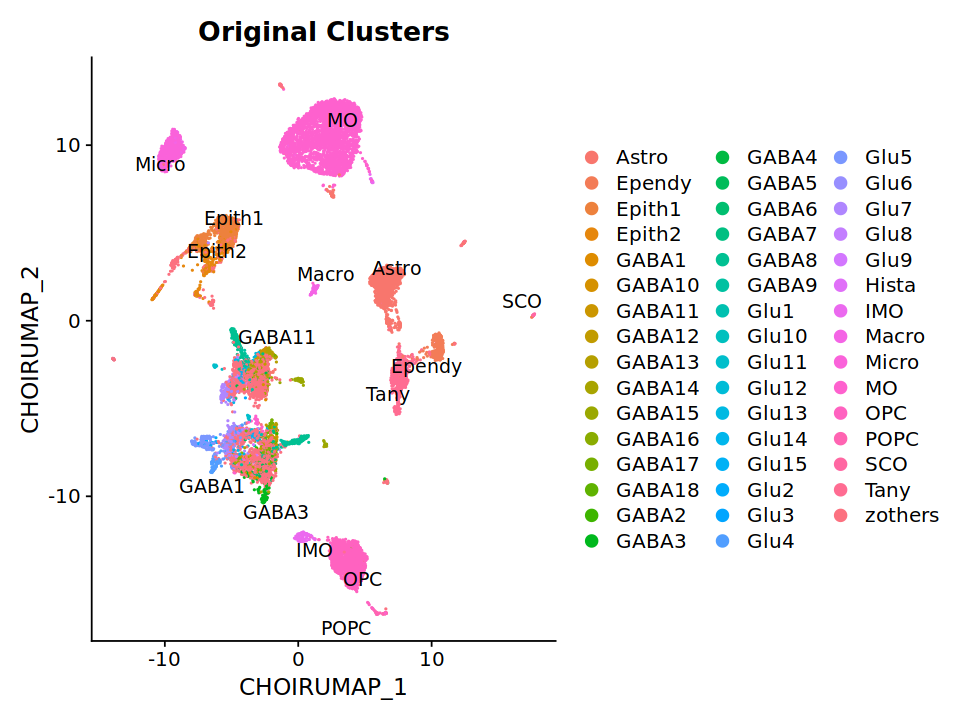

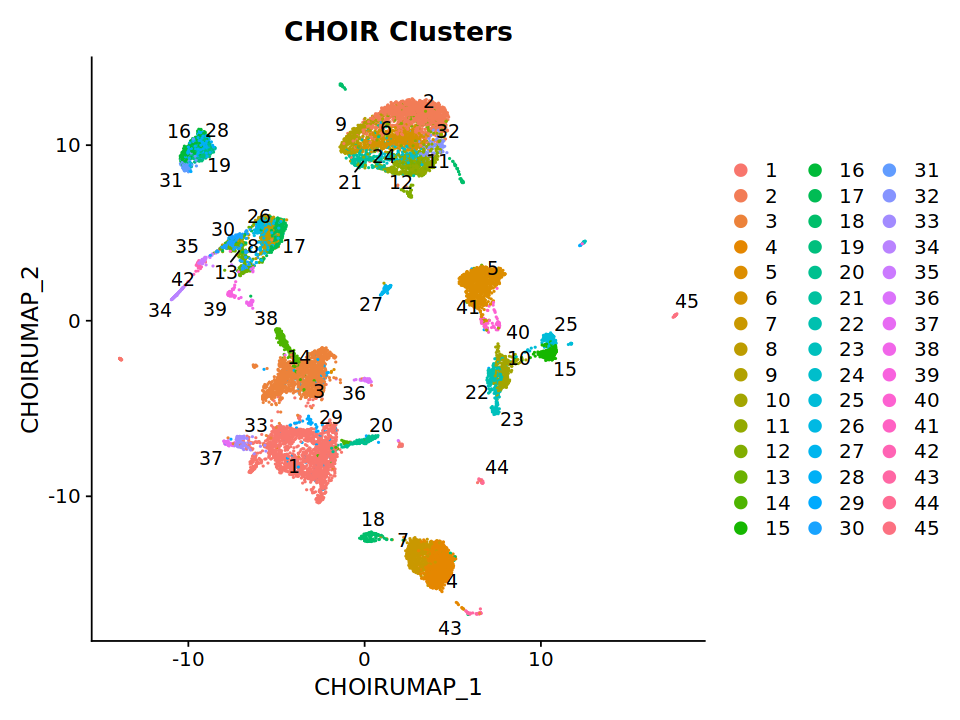

In [57]:
options(repr.plot.width = 8, repr.plot.height = 6)

# UMAP colored by original cluster labels
DimPlot(object, reduction = "CHOIR_UMAP", group.by = "Original_Cluster", label = TRUE, repel = TRUE) + 
  ggtitle("Original Clusters")

# UMAP colored by CHOIR clusters
DimPlot(object, reduction = "CHOIR_UMAP", group.by = "CHOIR_clusters_0.05", label = TRUE, repel = TRUE) + 
  ggtitle("CHOIR Clusters")

## Analyze OPCs (Original Cluster) which has been divded in CHOIR clusters 4 and 7

In [58]:
# Get markers for CHOIR clusters 4 and 7
# tells which genes are most upregulated in each of those two CHOIR subclusters that contain OPCs
opc_markers <- all_markers_annotated %>% 
  dplyr::filter(cluster %in% c(4, 7)) %>%    # cluster represents CHOIR cluster
  arrange(cluster, desc(avg_log2FC))

In [59]:
opc_markers

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,gene_symbol,ensembl_id,feature_num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>
0.000000e+00,3.525630,0.649,0.070,0.000000e+00,7,Feature2985,C1ql1,NA,2985
7.649639e-173,3.429119,0.294,0.036,1.184088e-168,7,Feature2310,Ascl1,NA,2310
0.000000e+00,3.414125,0.865,0.100,0.000000e+00,7,Feature13975,Pdgfra,NA,13975
2.242790e-135,3.307507,0.255,0.034,3.471614e-131,7,Feature3891,Chst5,NA,3891
0.000000e+00,3.271389,0.886,0.173,0.000000e+00,7,Feature9809,Lhfpl3,NA,9809
4.073134e-243,3.236945,0.502,0.079,6.304804e-239,7,Feature13824,Pcdh15,NA,13824
1.762038e-140,3.185296,0.290,0.043,2.727458e-136,7,Feature2986,C1ql2,NA,2986
1.730579e-185,3.183078,0.404,0.065,2.678763e-181,7,Feature3183,Car8,NA,3183
0.000000e+00,3.164411,0.761,0.108,0.000000e+00,7,Feature19587,Vcan,NA,19587


## GO analysis

In [60]:
# Extract top genes per cluster
top_4 <- opc_markers %>% dplyr::filter(cluster == 4 & p_val_adj < 0.05) #%>% pull(gene_symbol) %>% head(50)
top_7 <- opc_markers %>% dplyr::filter(cluster == 7 & p_val_adj < 0.05) #%>% pull(gene_symbol) %>% head(50)

In [61]:
top_4
top_7

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,gene_symbol,ensembl_id,feature_num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>
0.000000e+00,4.488553,0.540,0.029,0.000000e+00,4,Feature5670,Emid1,NA,5670
0.000000e+00,4.359813,0.360,0.021,0.000000e+00,4,Feature1244,A930009A15Rik,NA,1244
0.000000e+00,4.288983,0.704,0.052,0.000000e+00,4,Feature10320,Matn4,NA,10320
0.000000e+00,4.268668,0.384,0.020,0.000000e+00,4,Feature5850,Etv4,NA,5850
0.000000e+00,4.267432,0.893,0.056,0.000000e+00,4,Feature13975,Pdgfra,NA,13975
0.000000e+00,4.267379,0.511,0.036,0.000000e+00,4,Feature15705,Rlbp1,NA,15705
0.000000e+00,4.148809,0.436,0.027,0.000000e+00,4,Feature17846,Susd5,NA,17846
0.000000e+00,4.147115,0.290,0.019,0.000000e+00,4,Feature3891,Chst5,NA,3891
0.000000e+00,4.134057,0.533,0.044,0.000000e+00,4,Feature17324,Snx22,NA,17324


p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,gene_symbol,ensembl_id,feature_num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>
0.000000e+00,3.525630,0.649,0.070,0.000000e+00,7,Feature2985,C1ql1,NA,2985
7.649639e-173,3.429119,0.294,0.036,1.184088e-168,7,Feature2310,Ascl1,NA,2310
0.000000e+00,3.414125,0.865,0.100,0.000000e+00,7,Feature13975,Pdgfra,NA,13975
2.242790e-135,3.307507,0.255,0.034,3.471614e-131,7,Feature3891,Chst5,NA,3891
0.000000e+00,3.271389,0.886,0.173,0.000000e+00,7,Feature9809,Lhfpl3,NA,9809
4.073134e-243,3.236945,0.502,0.079,6.304804e-239,7,Feature13824,Pcdh15,NA,13824
1.762038e-140,3.185296,0.290,0.043,2.727458e-136,7,Feature2986,C1ql2,NA,2986
1.730579e-185,3.183078,0.404,0.065,2.678763e-181,7,Feature3183,Car8,NA,3183
0.000000e+00,3.164411,0.761,0.108,0.000000e+00,7,Feature19587,Vcan,NA,19587


In [65]:
# Extract gene lists for the above
genes_4 <- top_4$gene_symbol
genes_7 <- top_7$gene_symbol

head(genes_4)
head(genes_7)

[1] "Emid1"         "A930009A15Rik" "Matn4"         "Etv4"         
[5] "Pdgfra"        "Rlbp1"

[1] "C1ql1"  "Ascl1"  "Pdgfra" "Chst5"  "Lhfpl3" "Pcdh15"

In [63]:
# Do GO enrichment analysis for the 2 gene lists
library(clusterProfiler)
library(org.Mm.eg.db)

ego_4 <- enrichGO(gene = genes_4,
                  OrgDb = org.Mm.eg.db,
                  keyType = "SYMBOL",
                  ont = "BP",  # Biological Process
                  pAdjustMethod = "BH",
                  qvalueCutoff = 0.05)

ego_7 <- enrichGO(gene = genes_7,
                  OrgDb = org.Mm.eg.db,
                  keyType = "SYMBOL",
                  ont = "BP",
                  pAdjustMethod = "BH",
                  qvalueCutoff = 0.05)


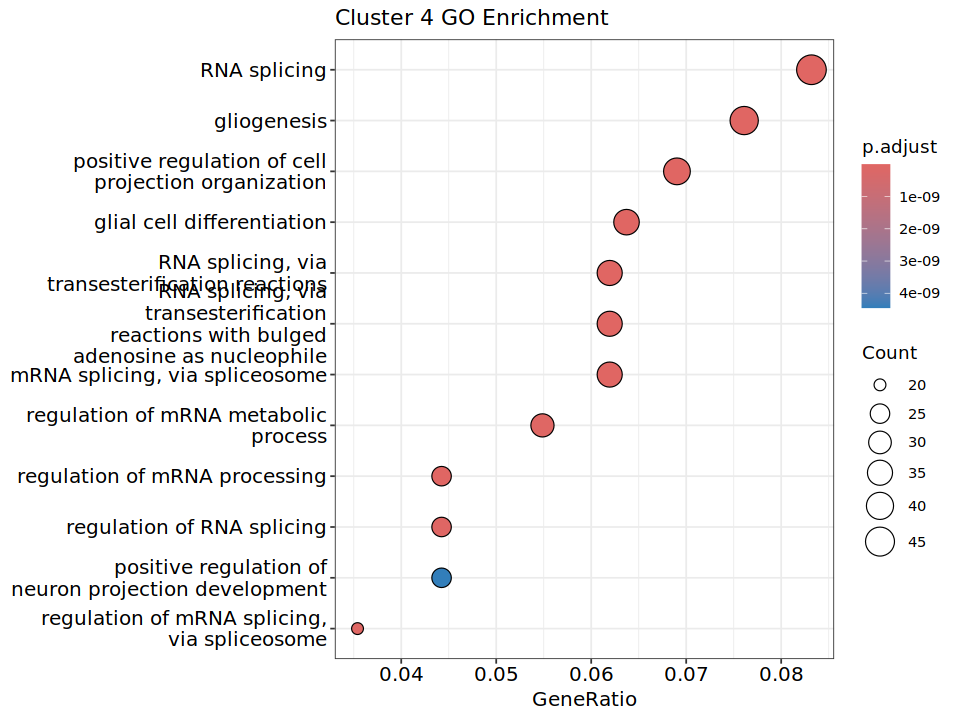

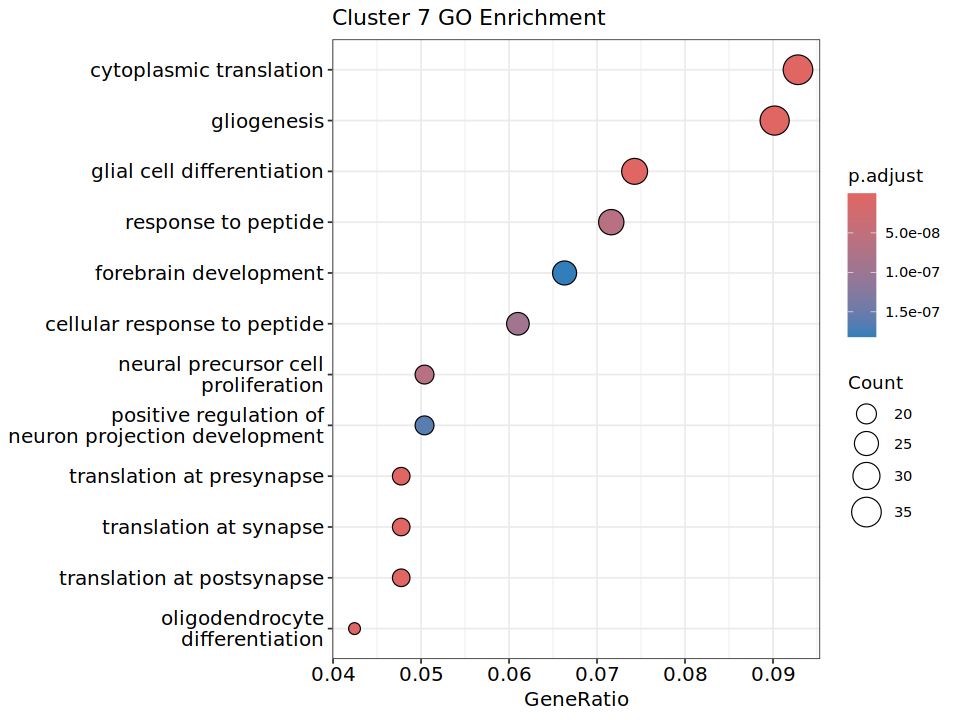

In [64]:
dotplot(ego_4, showCategory = 12, title = "Cluster 4 GO Enrichment")
dotplot(ego_7, showCategory = 12, title = "Cluster 7 GO Enrichment")

In [66]:
# View top GO enrichment processes/pathways
head(ego_4$Description)
head(ego_7$Description)

[1] "RNA splicing"                                                                        
[2] "gliogenesis"                                                                         
[3] "glial cell differentiation"                                                          
[4] "regulation of mRNA processing"                                                       
[5] "RNA splicing, via transesterification reactions"                                     
[6] "RNA splicing, via transesterification reactions with bulged adenosine as nucleophile"

[1] "cytoplasmic translation"    "translation at presynapse" 
[3] "translation at synapse"     "translation at postsynapse"
[5] "gliogenesis"                "glial cell differentiation"

## Evaluate the expression of Cluster 4 and Cluster 7 marker genes in every single cell

In [67]:
# Create a mapping vector
gene_module_map <- setNames(all_markers_annotated$gene, all_markers_annotated$gene_symbol)

In [70]:
# Convert gene symbols to Seurat gene names for each list
top4_genes <- gene_module_map[unlist(top_4)]
top4_genes <- top4_genes[!is.na(top4_genes)]

top7_genes <- gene_module_map[unlist(top_7)]
top7_genes <- top7_genes[!is.na(top7_genes)]

# AddModuleScore() summarizes a set of gene expressions (i.e., markers) into a single score per cell.
# Add module scores separately
module_object <- AddModuleScore(object, features = list(top4_genes, top7_genes), name = "ClusterScore")

# This gives you: ClusterScore1 and ClusterScore2
# ClusterScore1 = how strongly a cell expresses Cluster 4 genes.
# ClusterScore2 = how strongly it expresses Cluster 7 genes.

Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."


In [112]:
module_object@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,CHOIR_clusters_0.05,Original_Cluster,CHOIR_annotated,ClusterScore1,ClusterScore2
,<fct>,<dbl>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>
1,SeuratProject,12201,4216,10,Tany,46,0.26436147,0.3445464
2,SeuratProject,10470,3638,3,GABA12,47,0.15937596,0.2282738
3,SeuratProject,9394,3435,3,GABA12,47,0.12381320,0.2071745
4,SeuratProject,6646,2971,3,zothers,47,0.18989874,0.2202349
5,SeuratProject,6546,2883,15,Ependy,2,0.13939865,0.2643179
6,SeuratProject,6638,2338,18,MO,39,0.22303446,0.2583136
7,SeuratProject,6166,2729,3,GABA7,47,0.17201712,0.2725609
8,SeuratProject,5961,2189,32,MO,42,0.17290329,0.1916920
9,SeuratProject,5237,2458,15,Ependy,2,0.19028742,0.2999250


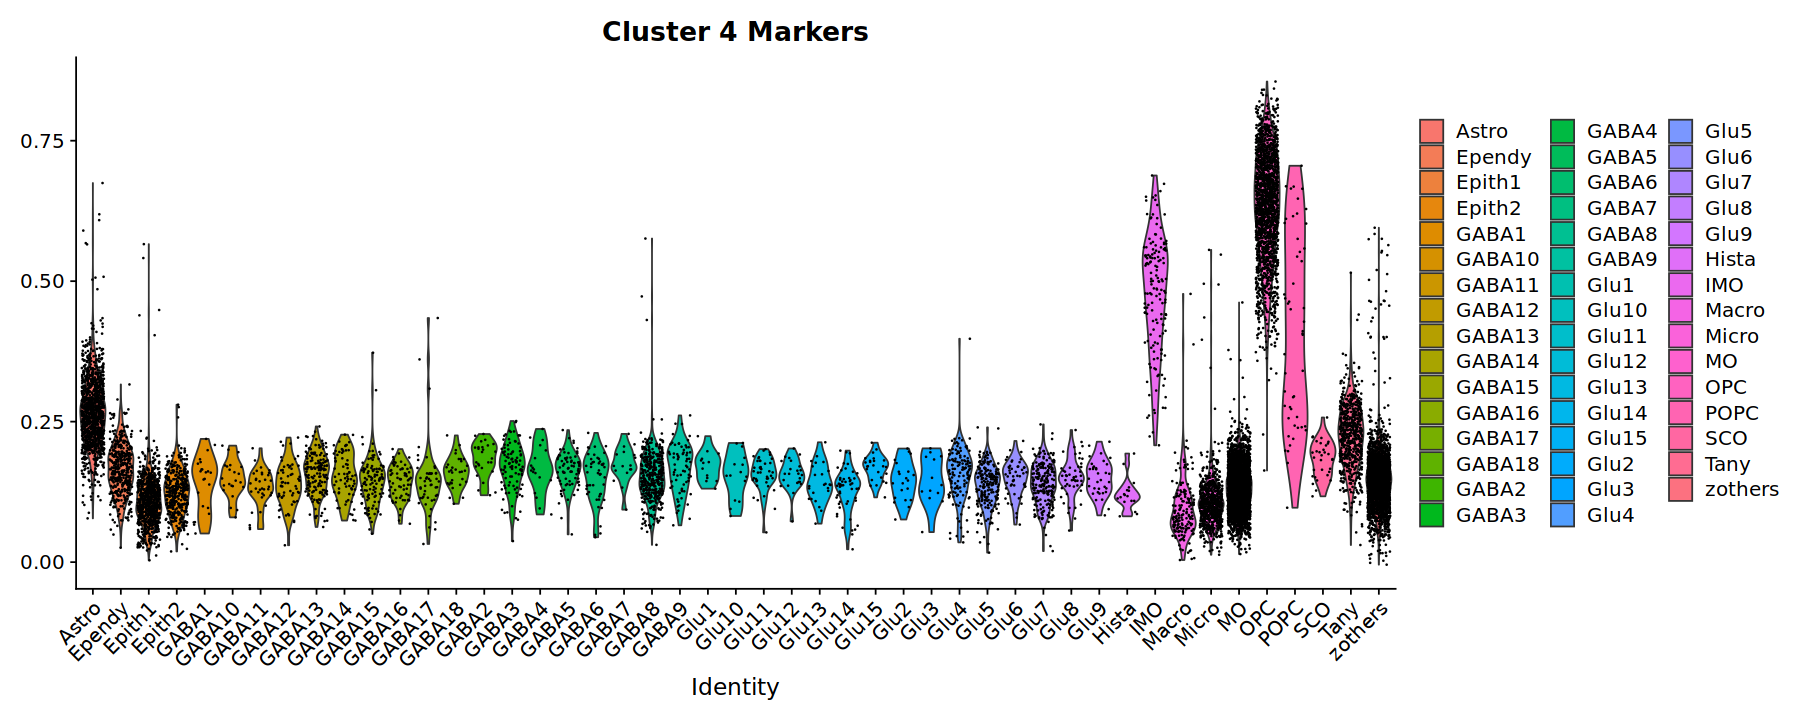

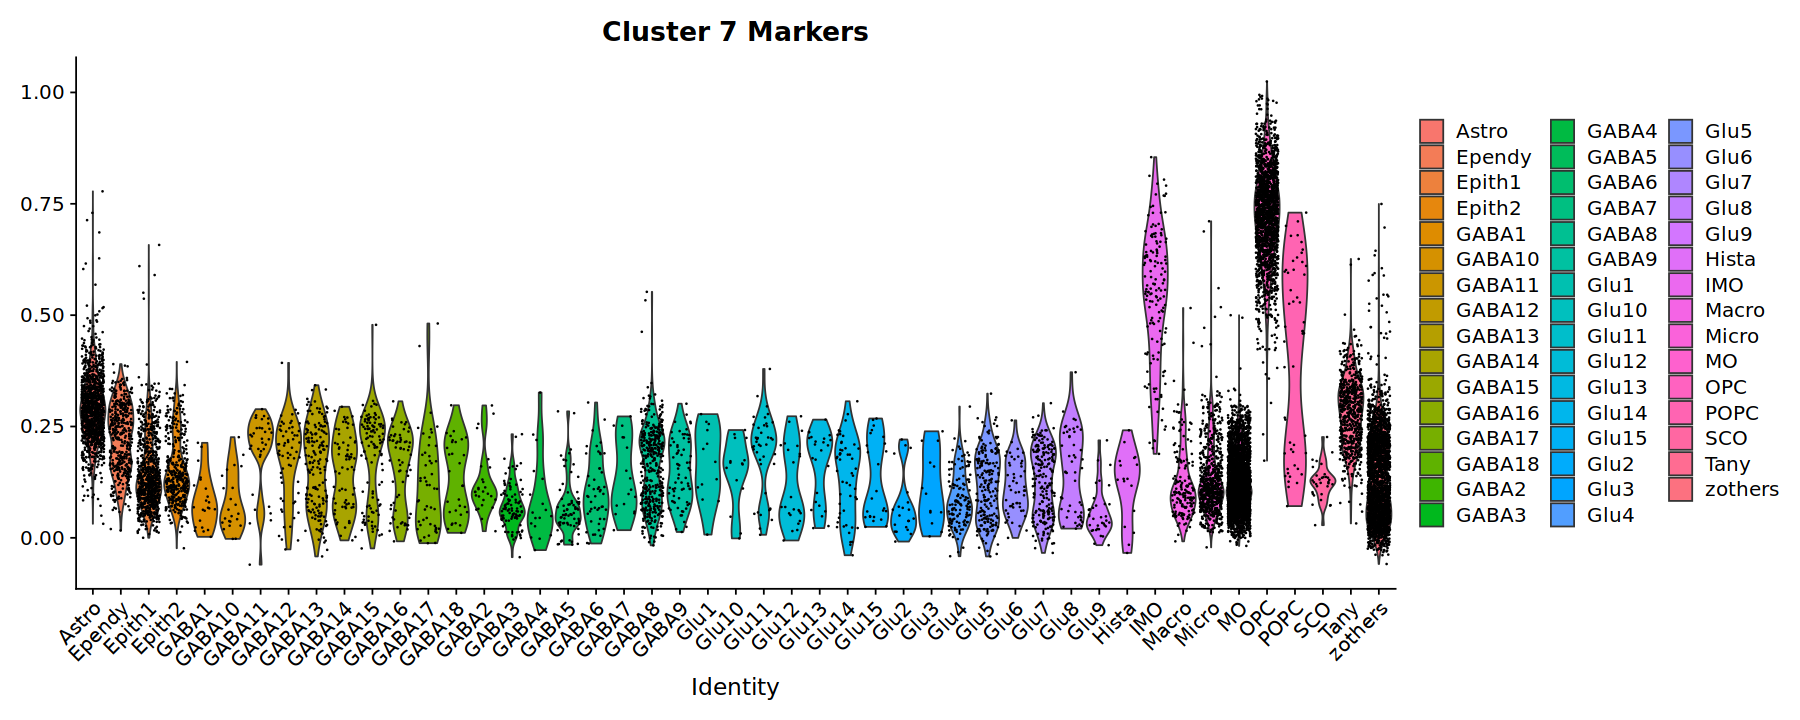

In [72]:
options(repr.plot.width = 15, repr.plot.height = 6)

VlnPlot(module_object, features = "ClusterScore1", group.by = "Original_Cluster") + ggtitle("Cluster 4 Markers")
VlnPlot(module_object, features = "ClusterScore2", group.by = "Original_Cluster") + ggtitle("Cluster 7 Markers")

In [75]:
# Extract the module scores and cluster assignments for all cells
# Extract module scores
score1 <- module_object@meta.data$ClusterScore1
score2 <- module_object@meta.data$ClusterScore2

# Extract cluster labels (replace with the actual cluster column name in your object)
clusters <- module_object@meta.data$Original_Cluster 

# Check lengths to confirm everything matches
length(score1)
length(score2)
length(clusters)

[1] 14426

[1] 14426

[1] 14426

In [113]:
# Subset cells belonging to cluster 4 based on CHOIR clustering
cluster4_cells <- subset(module_object, subset = CHOIR_clusters_0.05 == "4")

# Subset cells belonging to cluster 7 based on CHOIR clustering
cluster7_cells <- subset(module_object, subset = CHOIR_clusters_0.05 == "7")

# Extract ClusterScore1 (Cluster 4 marker expression) for cluster 4 cells
score1_cluster4 <- cluster4_cells@meta.data$ClusterScore1

# Extract ClusterScore2 (Cluster 7 marker expression) for cluster 4 cells
score2_cluster4 <- cluster4_cells@meta.data$ClusterScore2

# Wilcoxon signed-rank test (paired) to check if cluster 4 cells express their own markers (score1) significantly differently than cluster 7 markers (score2)
wilcox.test(score1_cluster4, score2_cluster4, paired = TRUE)

# Extract ClusterScore1 (Cluster 4 marker expression) for cluster 7 cells
score1_cluster7 <- cluster7_cells@meta.data$ClusterScore1

# Extract ClusterScore2 (Cluster 7 marker expression) for cluster 7 cells
score2_cluster7 <- cluster7_cells@meta.data$ClusterScore2

# Wilcoxon signed-rank test (paired) to check if cluster 7 cells express their own markers (score2) significantly differently than cluster 4 markers (score1)
wilcox.test(score2_cluster7, score1_cluster7, paired = TRUE)


	Wilcoxon signed rank test with continuity correction

data:  score1_cluster4 and score2_cluster4
V = 17813, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank test with continuity correction

data:  score2_cluster7 and score1_cluster7
V = 130305, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [76]:
# Create df for ClusterScore1
df1 <- data.frame(
  Cluster = as.factor(clusters),
  ModuleScore = score1
)

# Create df for ClusterScore2
df2 <- data.frame(
  Cluster = as.factor(clusters),
  ModuleScore = score2
)

In [80]:
# Median for ClusterScore1
aggregate(ModuleScore ~ Cluster, data = df1, FUN = median)

# Median for ClusterScore2
aggregate(ModuleScore ~ Cluster, data = df2, FUN = median)


Cluster,ModuleScore
<fct>,<dbl>
Astro,0.26497058
Ependy,0.16531052
Epith1,0.10576623
Epith2,0.12512822
GABA1,0.15921841
GABA10,0.14504070
GABA11,0.13091830
GABA12,0.13823846
GABA13,0.16361366


Cluster,ModuleScore
<fct>,<dbl>
Astro,0.28636803
Ependy,0.23419338
Epith1,0.12781877
Epith2,0.13465941
GABA1,0.06759080
GABA10,0.05415148
GABA11,0.22250193
GABA12,0.19411325
GABA13,0.17179720


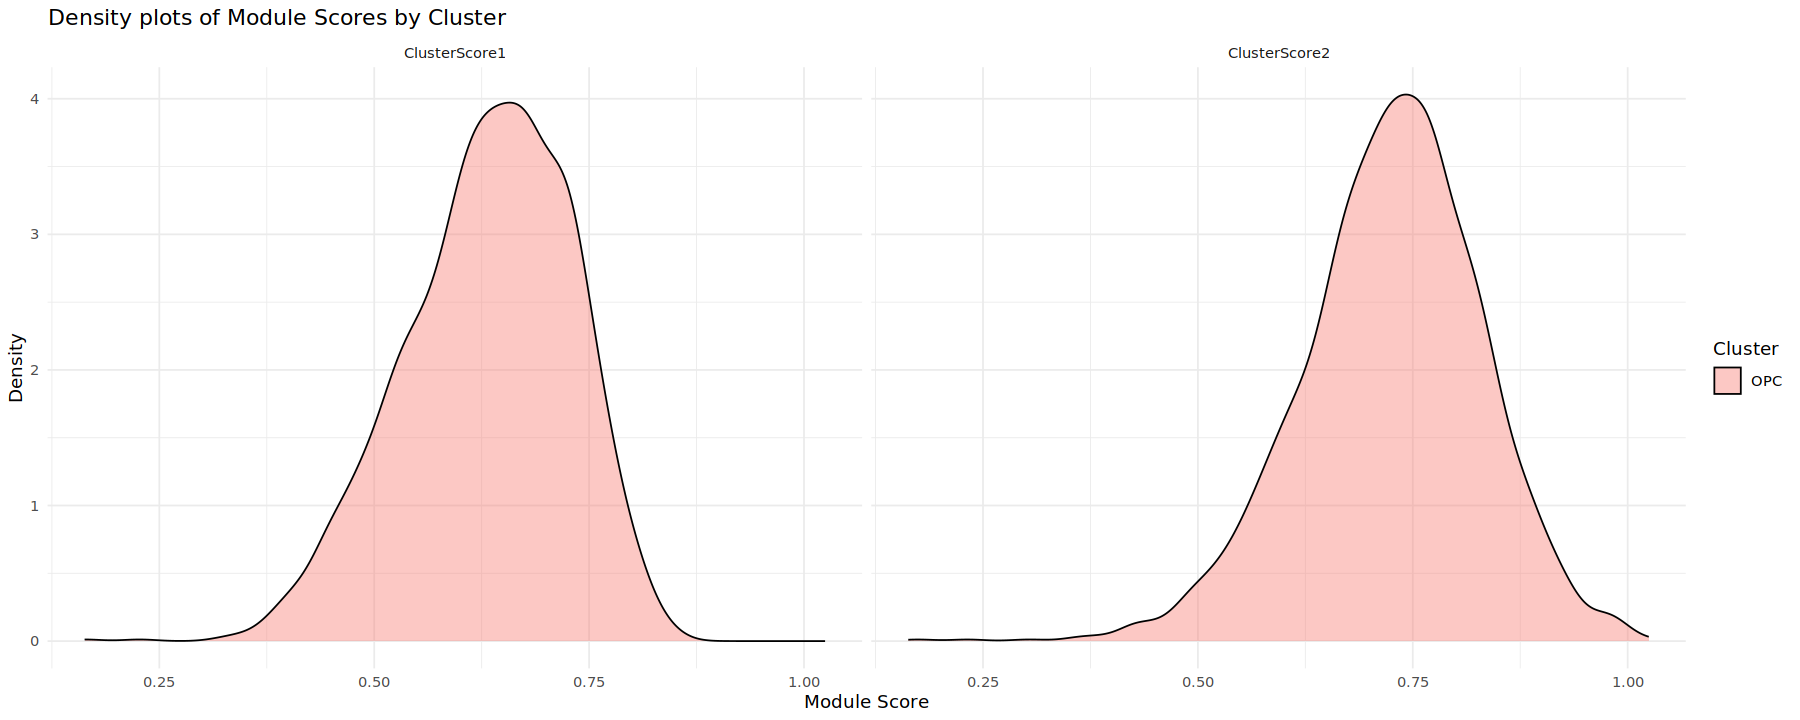

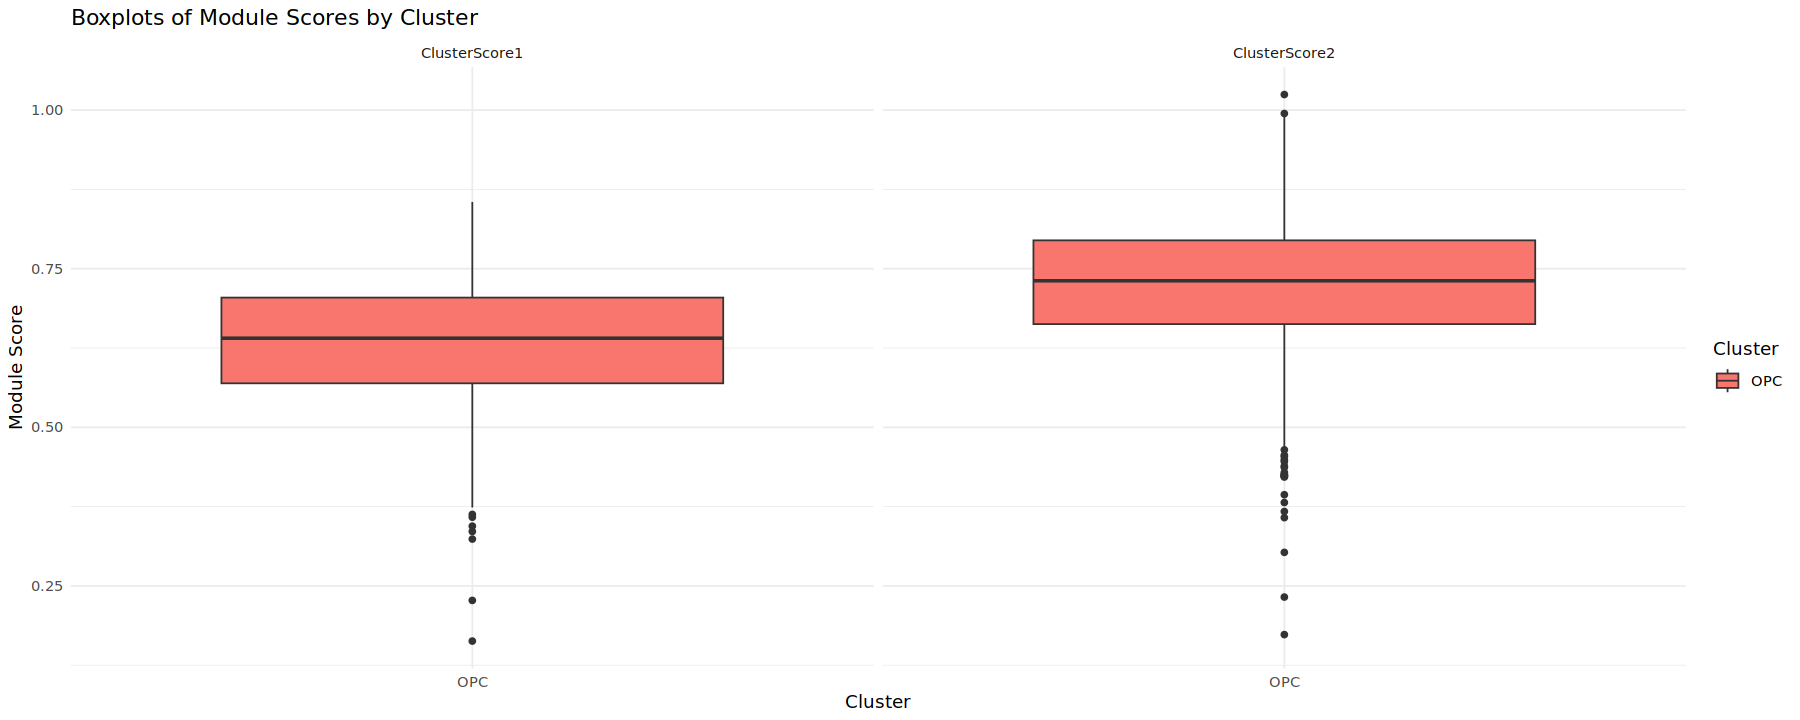

In [83]:
library(ggplot2)

# Combine data for easier plotting with a new column indicating the score type
df1$ScoreType <- "ClusterScore1"
df2$ScoreType <- "ClusterScore2"
combined_df <- rbind(df1, df2)

# Density plot
ggplot(combined_df[combined_df$Cluster %in% c("OPC"), ], aes(x = ModuleScore, fill = Cluster)) +
  geom_density(alpha = 0.4) +
  facet_wrap(~ScoreType) +
  theme_minimal() +
  labs(title = "Density plots of Module Scores by Cluster",
       x = "Module Score",
       y = "Density")

# Boxplot
ggplot(combined_df[combined_df$Cluster %in% c("OPC"), ], aes(x = Cluster, y = ModuleScore, fill = Cluster)) +
  geom_boxplot() +
  facet_wrap(~ScoreType) +
  theme_minimal() +
  labs(title = "Boxplots of Module Scores by Cluster",
       y = "Module Score")


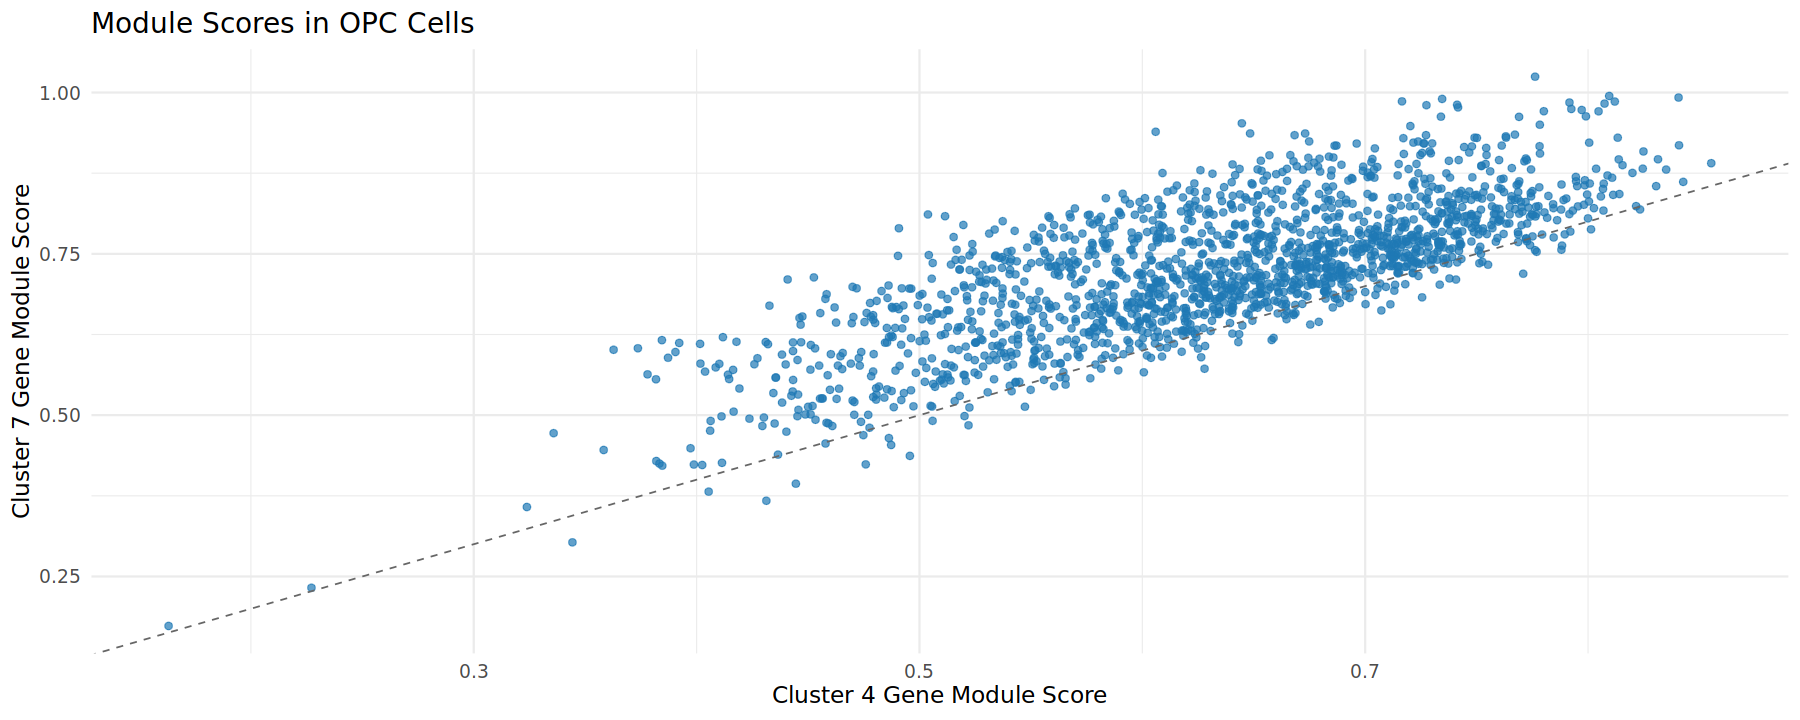

In [91]:
# Extract metadata
meta <- module_object@meta.data

# make original cluster column a factor
meta$original_cluster <- as.factor(meta$Original_Cluster)

# Filter only OPC cells
opc_cells <- rownames(meta[meta$original_cluster == "OPC", ])

# Plot
ggplot(meta[opc_cells, ], aes(x = ClusterScore1, y = ClusterScore2)) +
  geom_point(alpha = 0.7, size = 1.8, color = "#1f78b4") +
  labs(
    title = "Module Scores in OPC Cells",
    x = "Cluster 4 Gene Module Score",
    y = "Cluster 7 Gene Module Score"
  ) +
  theme_minimal(base_size = 14) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey40")